# Natural Language Processing Project - Mail Spam classifier

In this NLP project I will attempt to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews.

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

Let's get started!

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

## The Data

In [2]:
yelp = pd.read_csv('yelp.csv')

## Analysing Data

In [3]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [5]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


**Createing a new column called "text length" which is the number of words in the text column.**

In [6]:
yelp['text length'] = yelp['text'].apply(len)

# EDA

Let's explore the data

**Grid of 5 histograms of text length based off of the star ratings.**

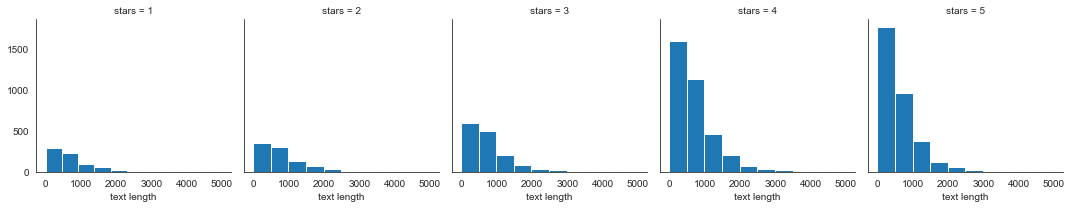

In [7]:
grid = sns.FacetGrid(yelp, col='stars')
grid.map(plt.hist, 'text length')

**Boxplot of text length for each star category.**

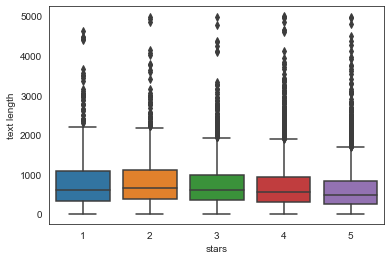

In [8]:
sns.boxplot(data=yelp, x='stars', y='text length')

**Countplot of the number of occurrences for each type of star rating.**

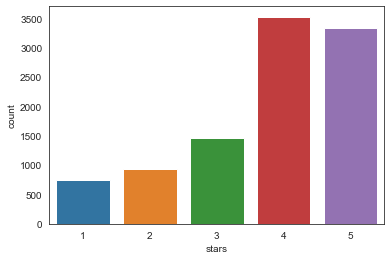

In [9]:
sns.countplot(data=yelp, x='stars')

**Grouping to get the mean values of the numerical columns.**

In [10]:
yelp.groupby('stars').mean()

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


**Correlation in the grouped data frame**

In [11]:
yelp.groupby('stars').mean().corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


**A heatmap based off that correlated dataframe**

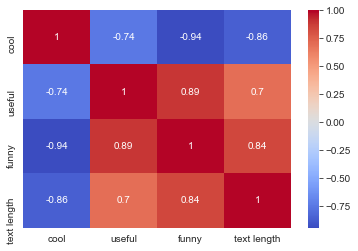

In [12]:
sns.heatmap(yelp.groupby('stars').mean().corr(), cmap='coolwarm', annot=True)

## NLP Classification Task

Let's move on to the actual task. To make things a little easier, we are grabbing reviews that were either 1 star or 5 stars.

**A dataframe called yelp_class that contains the columns of yelp dataframe but for only the 1 or 5 star reviews.**

In [13]:
yelp_class = yelp[(yelp.stars==1) | (yelp.stars==5)]

**Creating two objects X and y. X will be the 'text' column of yelp_class and y will be the 'stars' column of yelp_class. (Our features and target)**

In [14]:
X = yelp_class['text']
y = yelp_class['stars']

**Importing CountVectorizer and creating a CountVectorizer object.**

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [16]:
X = cv.fit_transform(X)

## Train Test Split

Let's split our data into training and testing data.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

## Training a Model

Time to train a model!

In [19]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [20]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predictions and Evaluations

Time to see how our model did!

In [21]:
predictions = nb.predict(X_test)

**Confusion matrix and classification report using these predictions and y_test**

In [22]:
from sklearn.metrics import confusion_matrix,classification_report

In [23]:
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[145  79]
 [ 26 976]]


              precision    recall  f1-score   support

           1       0.85      0.65      0.73       224
           5       0.93      0.97      0.95      1002

    accuracy                           0.91      1226
   macro avg       0.89      0.81      0.84      1226
weighted avg       0.91      0.91      0.91      1226



# Thanks